<a href="https://colab.research.google.com/github/DataMastersUN/FA_T3/blob/main/Trabajo_3_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **Fundamentos de Analítica**

##**Trabajo 3: Clasificación de Imágenes**

Integrantes:

David Antonio Castro Tamayo
dcastrot@unal.edu.co

Luis Javier Asprilla Galarcio
lasprilla@unal.edu.co

Anderson Elian Gutierrez Bueno
angutierrezb@unal.edu.co

</center>

Se tiene un conjunto de imágenes de personas con y sin gafas, en las que los individuos aparecen con diferentes expresiones faciales y ángulos, descargado de la fuente:https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images

Objetivo: Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas con el conjunto de datos dado.

In [251]:
# Librerias usadas
import os
import re
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import io
from random import shuffle
from tensorflow import keras
from collections import Counter
from keras.models import Sequential
from sklearn.decomposition import PCA
from random import randint, choice, choices
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, Activation, BatchNormalization
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# **Carga de datos**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


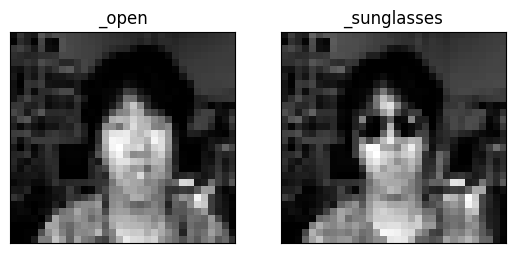

In [252]:
from google.colab import drive
drive.mount('/content/drive')

imagen_1 = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4/an2i/an2i_straight_sad_open_4.pgm')
imagen_2 = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4/an2i/an2i_straight_sad_sunglasses_4.pgm')
plt.subplot(1, 2, 1)
plt.imshow(imagen_1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('_open')

plt.subplot(1, 2, 2)
plt.imshow(imagen_2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('_sunglasses')

plt.show()

In [253]:
imagen_1.close()
imagen_2.close()

Los datos, tanto las imágenes como las etiquetas, se guardaron en dos únicos archivos binarios para evitar la carga reiterada de todas las imágenes desde el destino. Y se procede a cargar y trabajar con dichos ficheros.

In [254]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'

with open(ruta_archivo, 'rb') as archivo:
    images = pickle.load(archivo)
print(f'Se encontraron {len(images)} imágenes PGM.')

Se encontraron 624 imágenes PGM.


In [255]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'

with open(ruta_archivo, 'rb') as archivo:
    etiquetas = pickle.load(archivo)
print(f'Se encontraron {len(etiquetas)} etiquetas')

Se encontraron 624 etiquetas


In [256]:
#guardado unicamente de las etiquetas 'open' y 'sunglasses'
labels = [ruta.split('_')[-2].split('.')[0] for ruta in etiquetas]

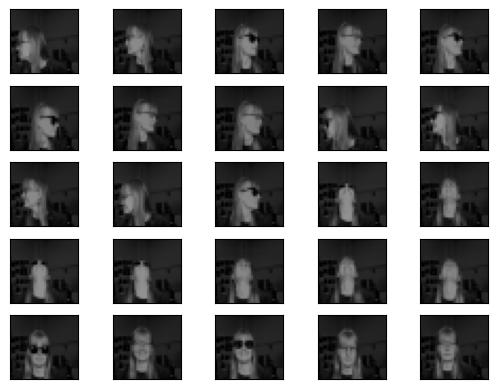

In [257]:
#Muestra de las imágenes cargadas
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [258]:
images[7].shape

(30, 32, 3)

Estos números representan en la imagen actual, el alto, ancho y canales de color, respectivamente. El canal de color con el valor de 3 hace referencia a que cada pixel tiene tres valores: rojo, verde y azul.

# **Preprocesamiento de datos**

## Transformación a escala de grises, redimensionamiento y normalización de imágenes

In [259]:
#Transformación explícita a grises
images_gray = []
for i in range(len(images)):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(image)

images_gray[4].shape

(30, 32)

Ahora sólo aparecen dos valores, alto y ancho, indicando que, actualmente, las imágenes se encuentran guardadas en escala de grises con una sola dimensión de canal. En cada píxel en la imagen en blanco y negro, los valores suelen estar en el rango de 0 a 255, donde 0 representa negro y 255 representa blanco, los valores intermedios representan tonos de gris.

Esta dimensión de alto y ancho es la que se utilizará a continuación para estandarizar todas las imágenes a una misma dimensión.

In [260]:
#Redimensión de todas las imagenes a un tamaño estandar de 30x32
new_height = images[0].shape[0]
new_width = images[0].shape[1]
images_proc = []
for i in range(len(images_gray)):
    image = cv2.resize(images_gray[i],(new_width, new_height))
    images_proc.append(image)

Luego de la redimensión, se procede con la **normalización de pixeles**, dividiendo cada valor de píxel por el valor máximo posible (255 en el caso de imágenes en escala de grises).
Esto normalizará los valores de píxeles en el rango de [0, 1].

In [261]:
#Normalización
images_normalized = []
for i in range(len(images_proc)):
    image = images_proc[i] / 255.0
    images_normalized.append(image)

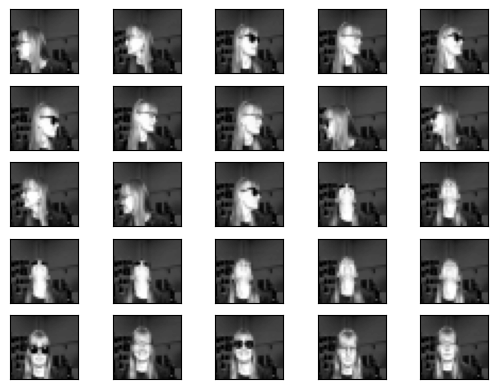

In [262]:
#Muestra de imágenes para ver el estado de las mismas luego de las transformaciones
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_normalized[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

# **Análisis de componentes principales**

Se procede primero con el aplanamiento de las imágenes en un vector. Segundo, la descomposición espectral, en la que se sacan los eigenvalores y eigenvectores que servirán para el posterior análisis de PCA (Principal Component Analysis) en la varianza explicada acumulada

In [263]:
#Aplanamiento de imágenes
img_vectorizadas = [i.flatten() for i in images_normalized]
imagenes_matriz = np.vstack(img_vectorizadas)
imagenes_matriz = imagenes_matriz-imagenes_matriz.mean()
print(imagenes_matriz.shape)

(624, 960)


In [264]:
#descomposicion eigenvectores y valores
S = np.corrcoef(imagenes_matriz.T)
eigenvalues, eigenvectors = np.linalg.eigh(S)

In [265]:
#varianza total, individual, acumulada
var_total = eigenvalues.sum()
var_ind = eigenvalues[::-1]/var_total
var_acum = var_ind.cumsum()

In [266]:
nombres_pc = []
for i in range(len(eigenvalues)):
    nombres_pc.append('PC' + str(i+1))

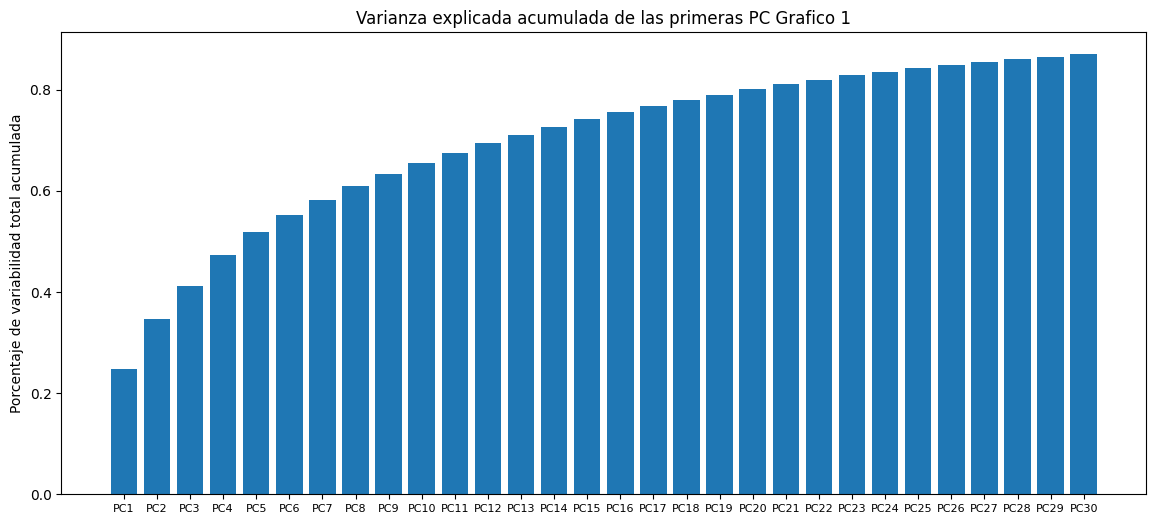

In [267]:
# Visualización de la varianza explicada acumulada:
fig = plt.figure(figsize=(14, 6))
plt.bar(x=nombres_pc[:30], height = var_acum[:30])
plt.xticks(fontsize=8)
plt.ylabel('Porcentaje de variabilidad total acumulada')
plt.title('Varianza explicada acumulada de las primeras PC Grafico 1')
plt.show()

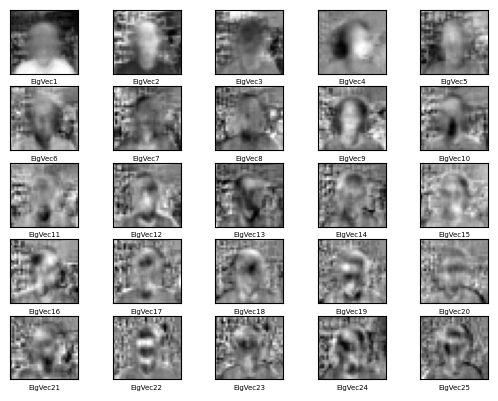

In [268]:
#Vectores propios como imagen
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(eigenvectors[:,-(i+1)].reshape(images_gray[0].shape), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('EigVec' + str(i+1), fontsize = 5)
plt.show()

In [269]:
#Proyecciones en la primeras n_comp componentes principales:
n_comp = 10
n_obs = len(images_normalized)
proy_pc = np.empty((n_obs,n_comp), dtype = 'float')

for i in range(len(images_normalized)):
  for j in range(n_comp):
    proy_pc[i,j] = np.dot(eigenvectors[:,-j], imagenes_matriz[i,:])

proy_pc.shape

(624, 10)

In [270]:
Proy_PC = pd.DataFrame(proy_pc)
Proy_PC.columns = nombres_pc[0:n_comp]
Proy_PC.corr()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
PC1   1.000000 -0.695819  0.205561 -0.143283  0.146540 -0.181914 -0.374617   
PC2  -0.695819  1.000000 -0.577609  0.521755  0.147004 -0.062982  0.578617   
PC3   0.205561 -0.577609  1.000000 -0.570366  0.121133  0.450120 -0.309344   
PC4  -0.143283  0.521755 -0.570366  1.000000  0.095183 -0.391227  0.085956   
PC5   0.146540  0.147004  0.121133  0.095183  1.000000 -0.003066  0.093420   
PC6  -0.181914 -0.062982  0.450120 -0.391227 -0.003066  1.000000  0.131553   
PC7  -0.374617  0.578617 -0.309344  0.085956  0.093420  0.131553  1.000000   
PC8  -0.059525  0.077461 -0.160421  0.201458 -0.022716 -0.055021 -0.060938   
PC9   0.497299 -0.394261  0.168244 -0.238846 -0.196826 -0.006066 -0.100240   
PC10 -0.196479  0.050379  0.087131 -0.140270 -0.193764  0.392643  0.113475   

           PC8       PC9      PC10  
PC1  -0.059525  0.497299 -0.196479  
PC2   0.077461 -0.394261  0.050379  
PC3  -0.160421  0.168244  0.087131  
PC4   0.201458 -0.238846 -0.140270  
PC5  -0.022716 -0.196826 -0.193764  
PC6  -0.055021 -0.006066  0.392643  
PC7  -0.060938 -0.100240  0.113475  
PC8   1.000000 -0.027185 -0.015979  
PC9  -0.027185  1.000000 -0.147862  
PC10 -0.015979 -0.147862  1.000000

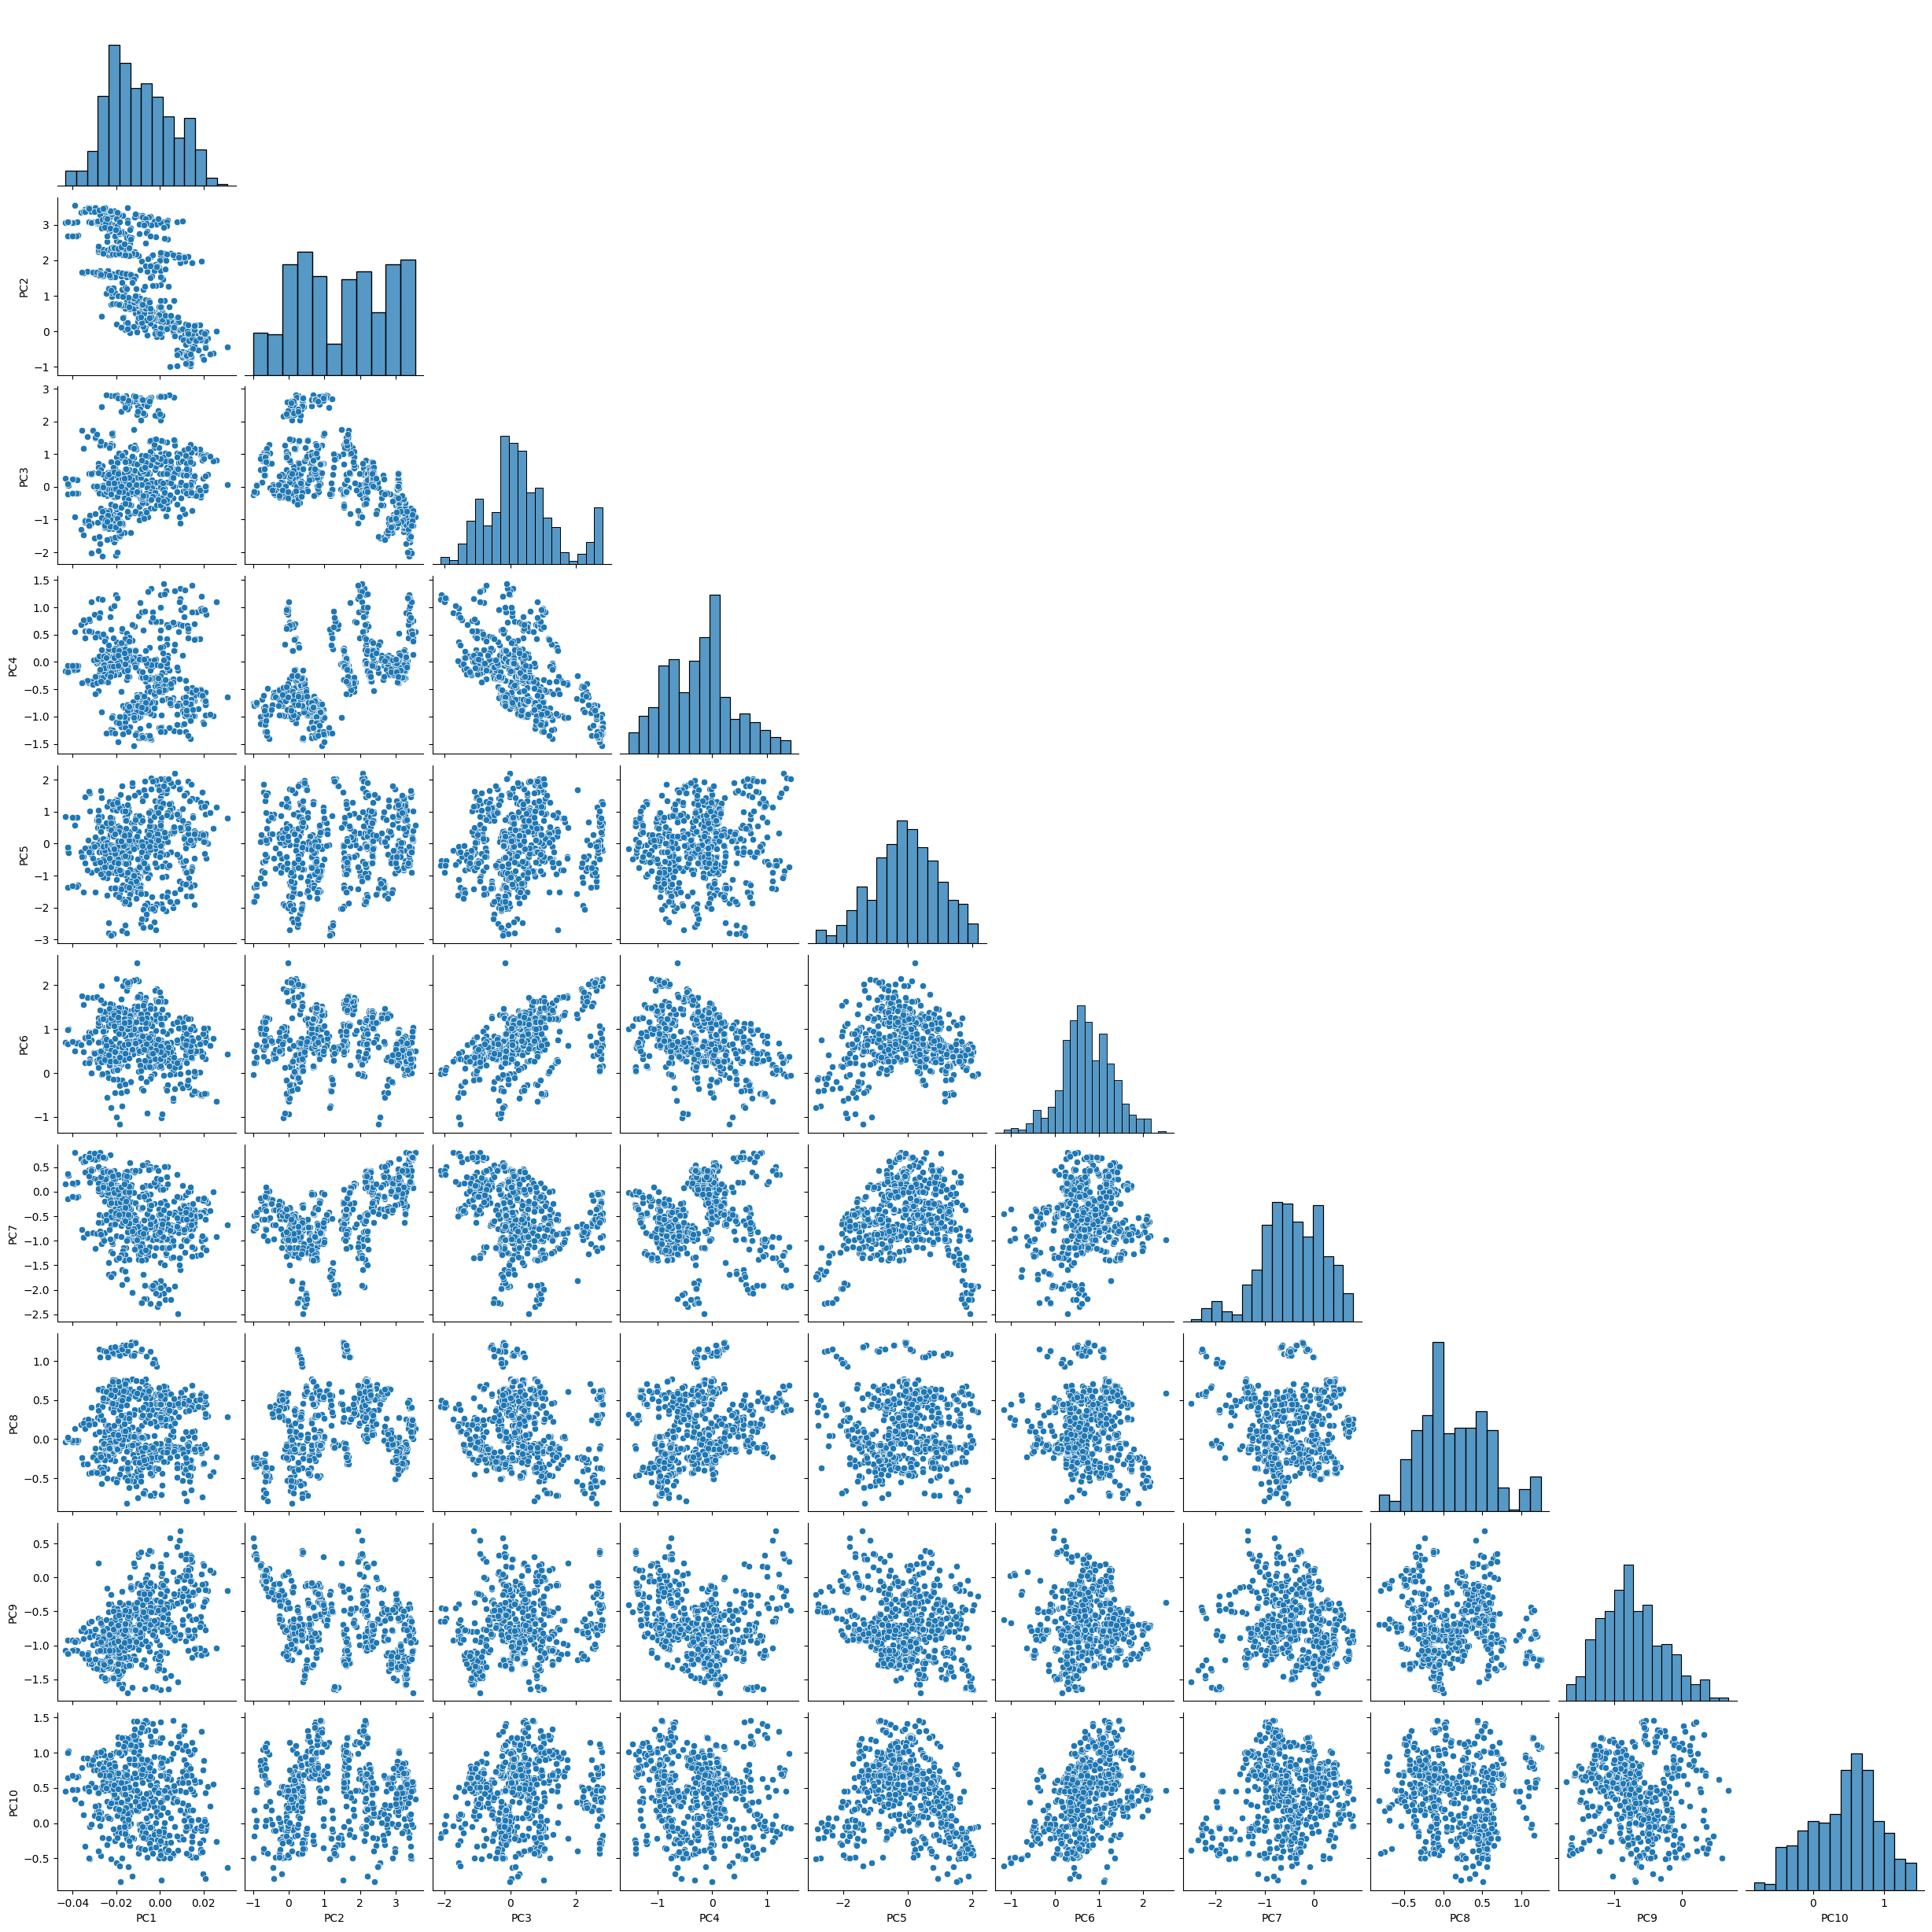

In [271]:
sns.pairplot(Proy_PC, corner = True)

In [272]:
#Extracción de las características de las imágenes de los nombres del archivo
patron = r"/faces_4/(\w+)/\w+_(\w+)_(\w+)_(\w+)_(\d+)\.pgm"

#Iterar sobre las etiquetas y extraer la información
resultados = [(re.search(patron, etiqueta).groups() if re.search(patron, etiqueta) else None) for etiqueta in etiquetas]

#Filtrar resultados no nulos
resultados = [res for res in resultados if res]

#Desempaquetar resultados en listas separadas
sujetos, perfiles, expresiones, ojos, numeros = zip(*resultados)

print(f"Sujetos: {sujetos}")
print(f"Perfiles: {perfiles}")
print(f"Expresiones: {expresiones}")
print(f"Ojos: {ojos}")
print(f"Números: {numeros}")

Sujetos: ('an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'an2i', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'ch4f', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'choon', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', 'danieln', '

# **Visualizacion de la relación entre variables**

Esta primera visualización muestra la relación entre las variables originales (perfiles del rostro, ojos, expresion) en un espacio bidimensional. La variable 'ojos' hace referencia a la característica de si lleva gafas (sunglasses) o no (open). Cada punto en el gráfico representa una combinación específica de los valores de estas variables.

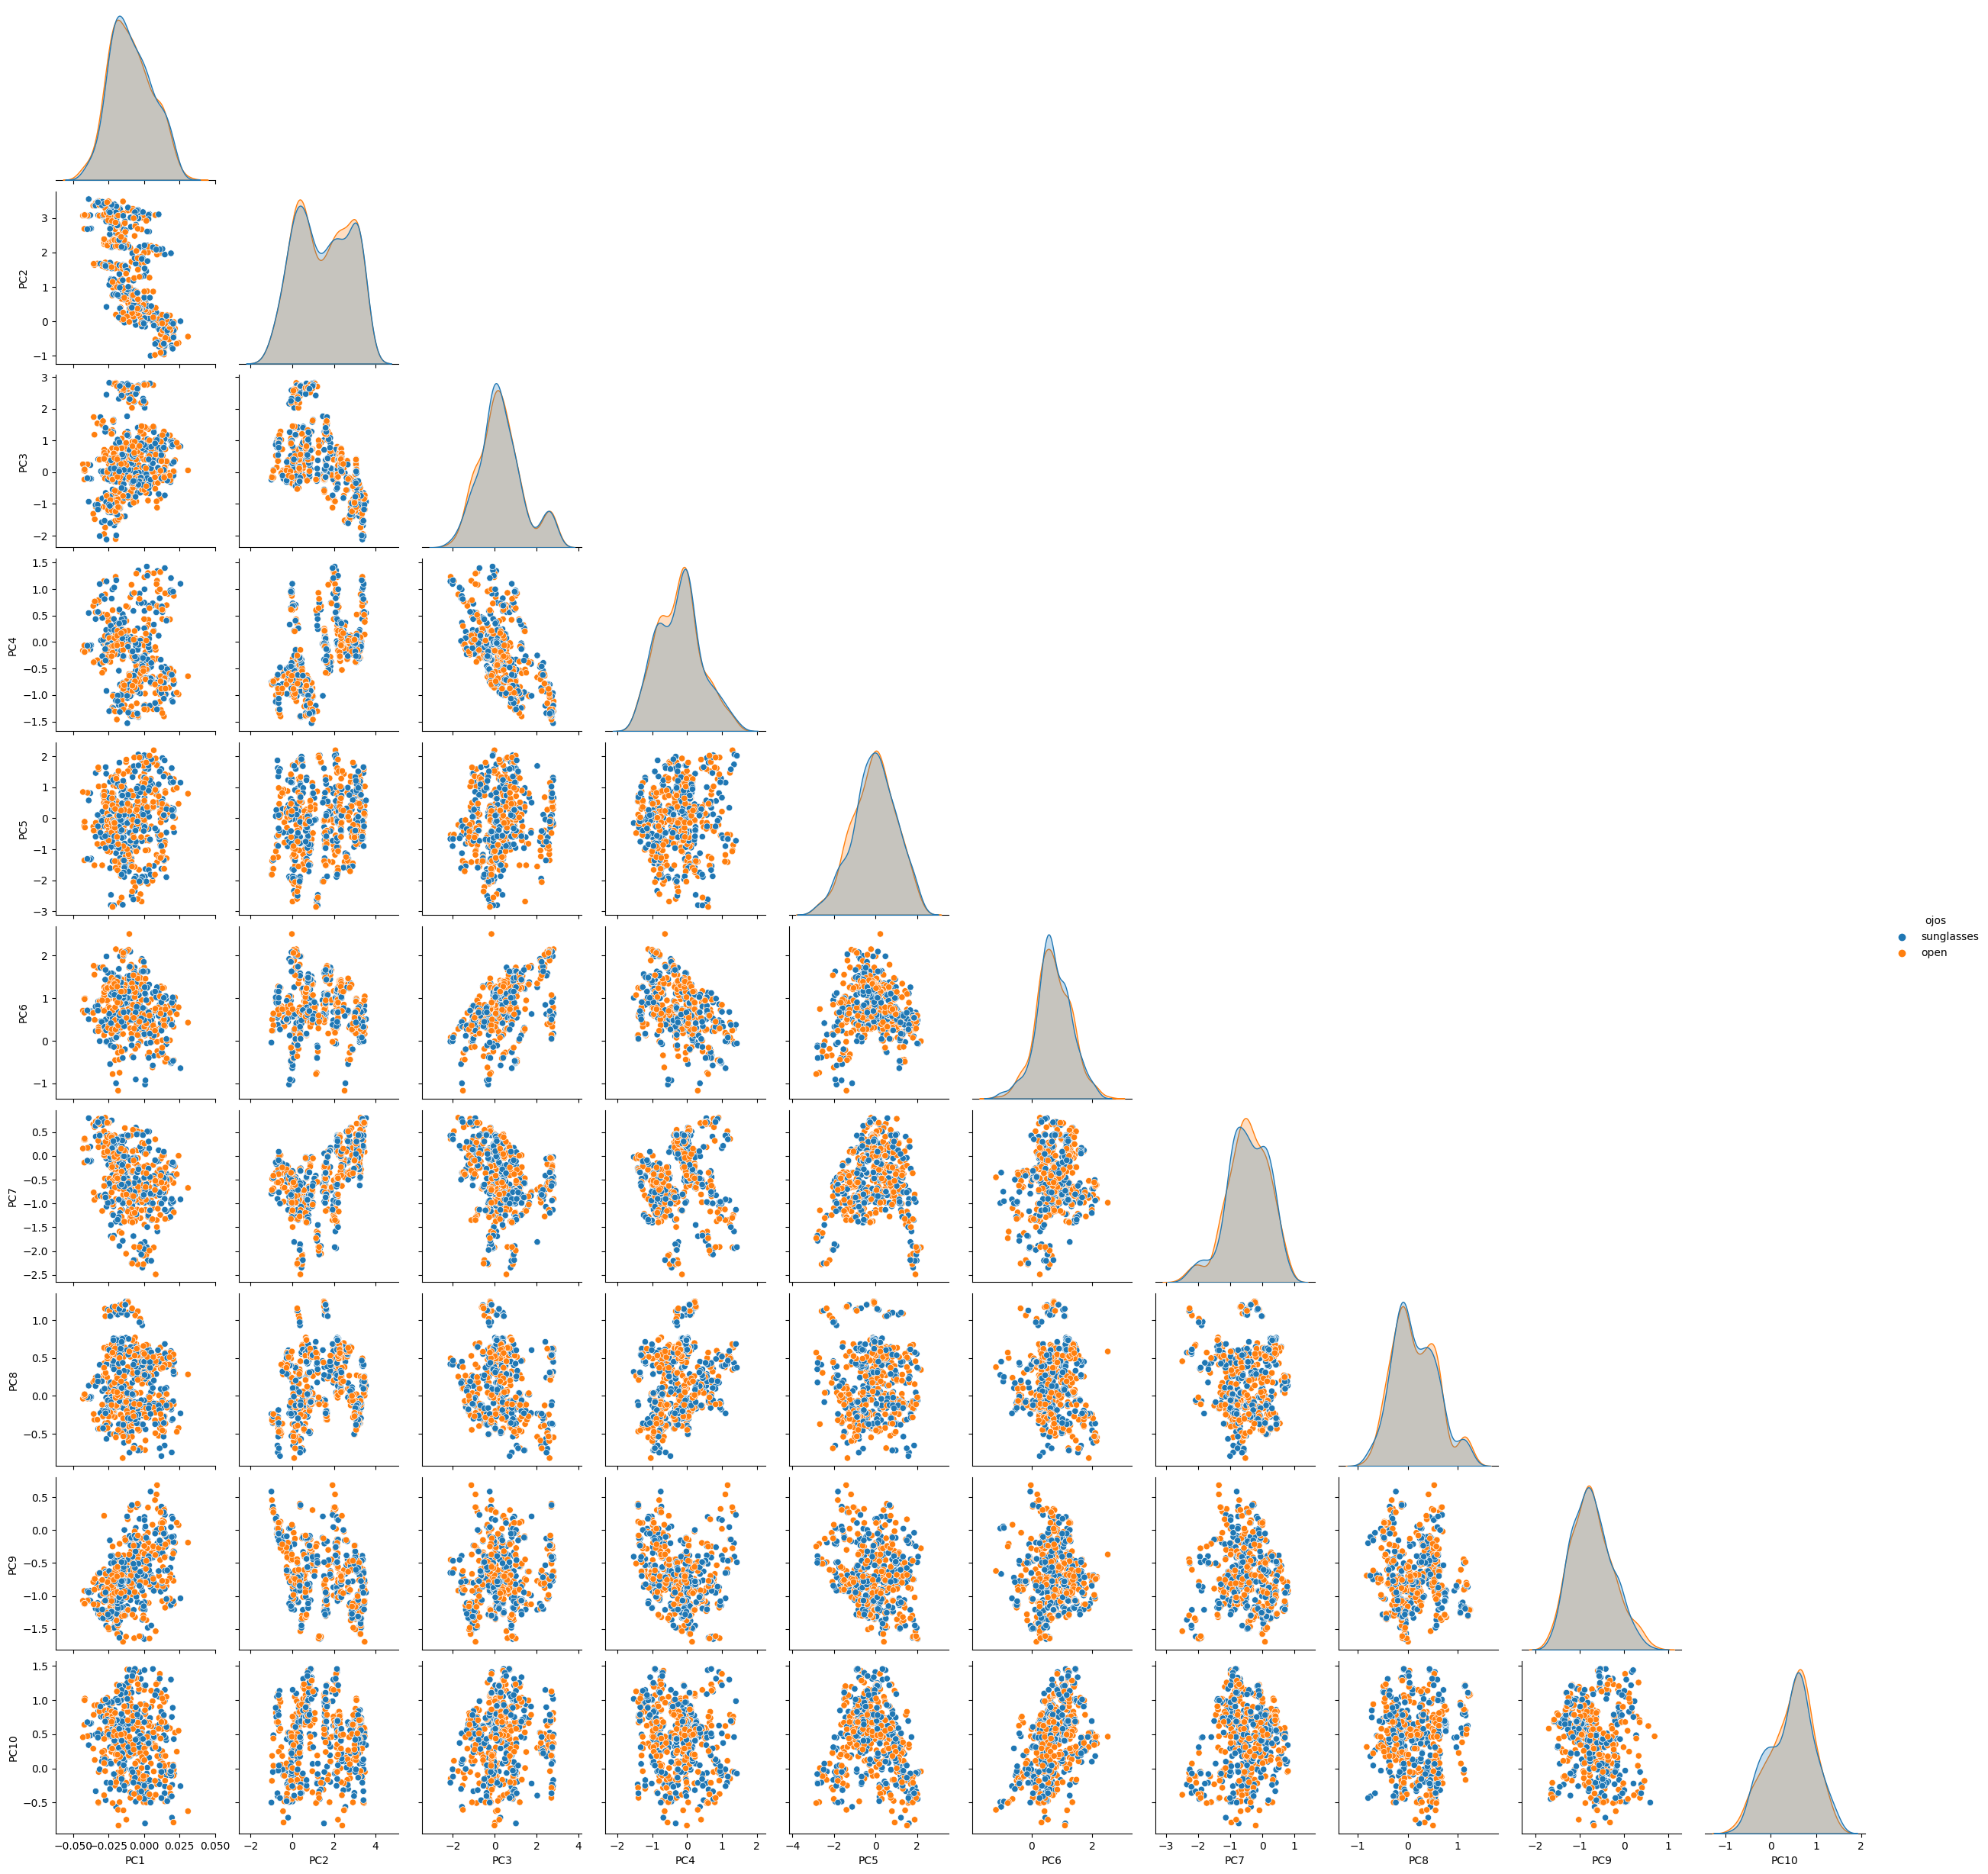

In [273]:
Proy_PC['perfiles'] = perfiles
Proy_PC['ojos'] = ojos
Proy_PC['expresion'] = expresiones

sns.pairplot(Proy_PC, corner = True, hue = 'ojos')

In [274]:
descomposicion_imagenes = PCA()
descomposicion_imagenes.fit(imagenes_matriz)

PCA()

In [275]:
Proy2 = descomposicion_imagenes.transform(imagenes_matriz)
Proy2 = pd.DataFrame(Proy2[:,0:n_comp])
Proy2.columns = nombres_pc[0:n_comp]

Proy2['perfiles'] = perfiles
Proy2['ojos'] = ojos
Proy2['expresion'] = expresiones

Esta segunda visualización mostrada a continuación utiliza PCA para reducir la dimensionalidad de los datos originales y mostrar las primeras componentes principales. Este enfoque puede ayudar a capturar la variabilidad más importante en los datos, lo que a menudo facilita la visualización.

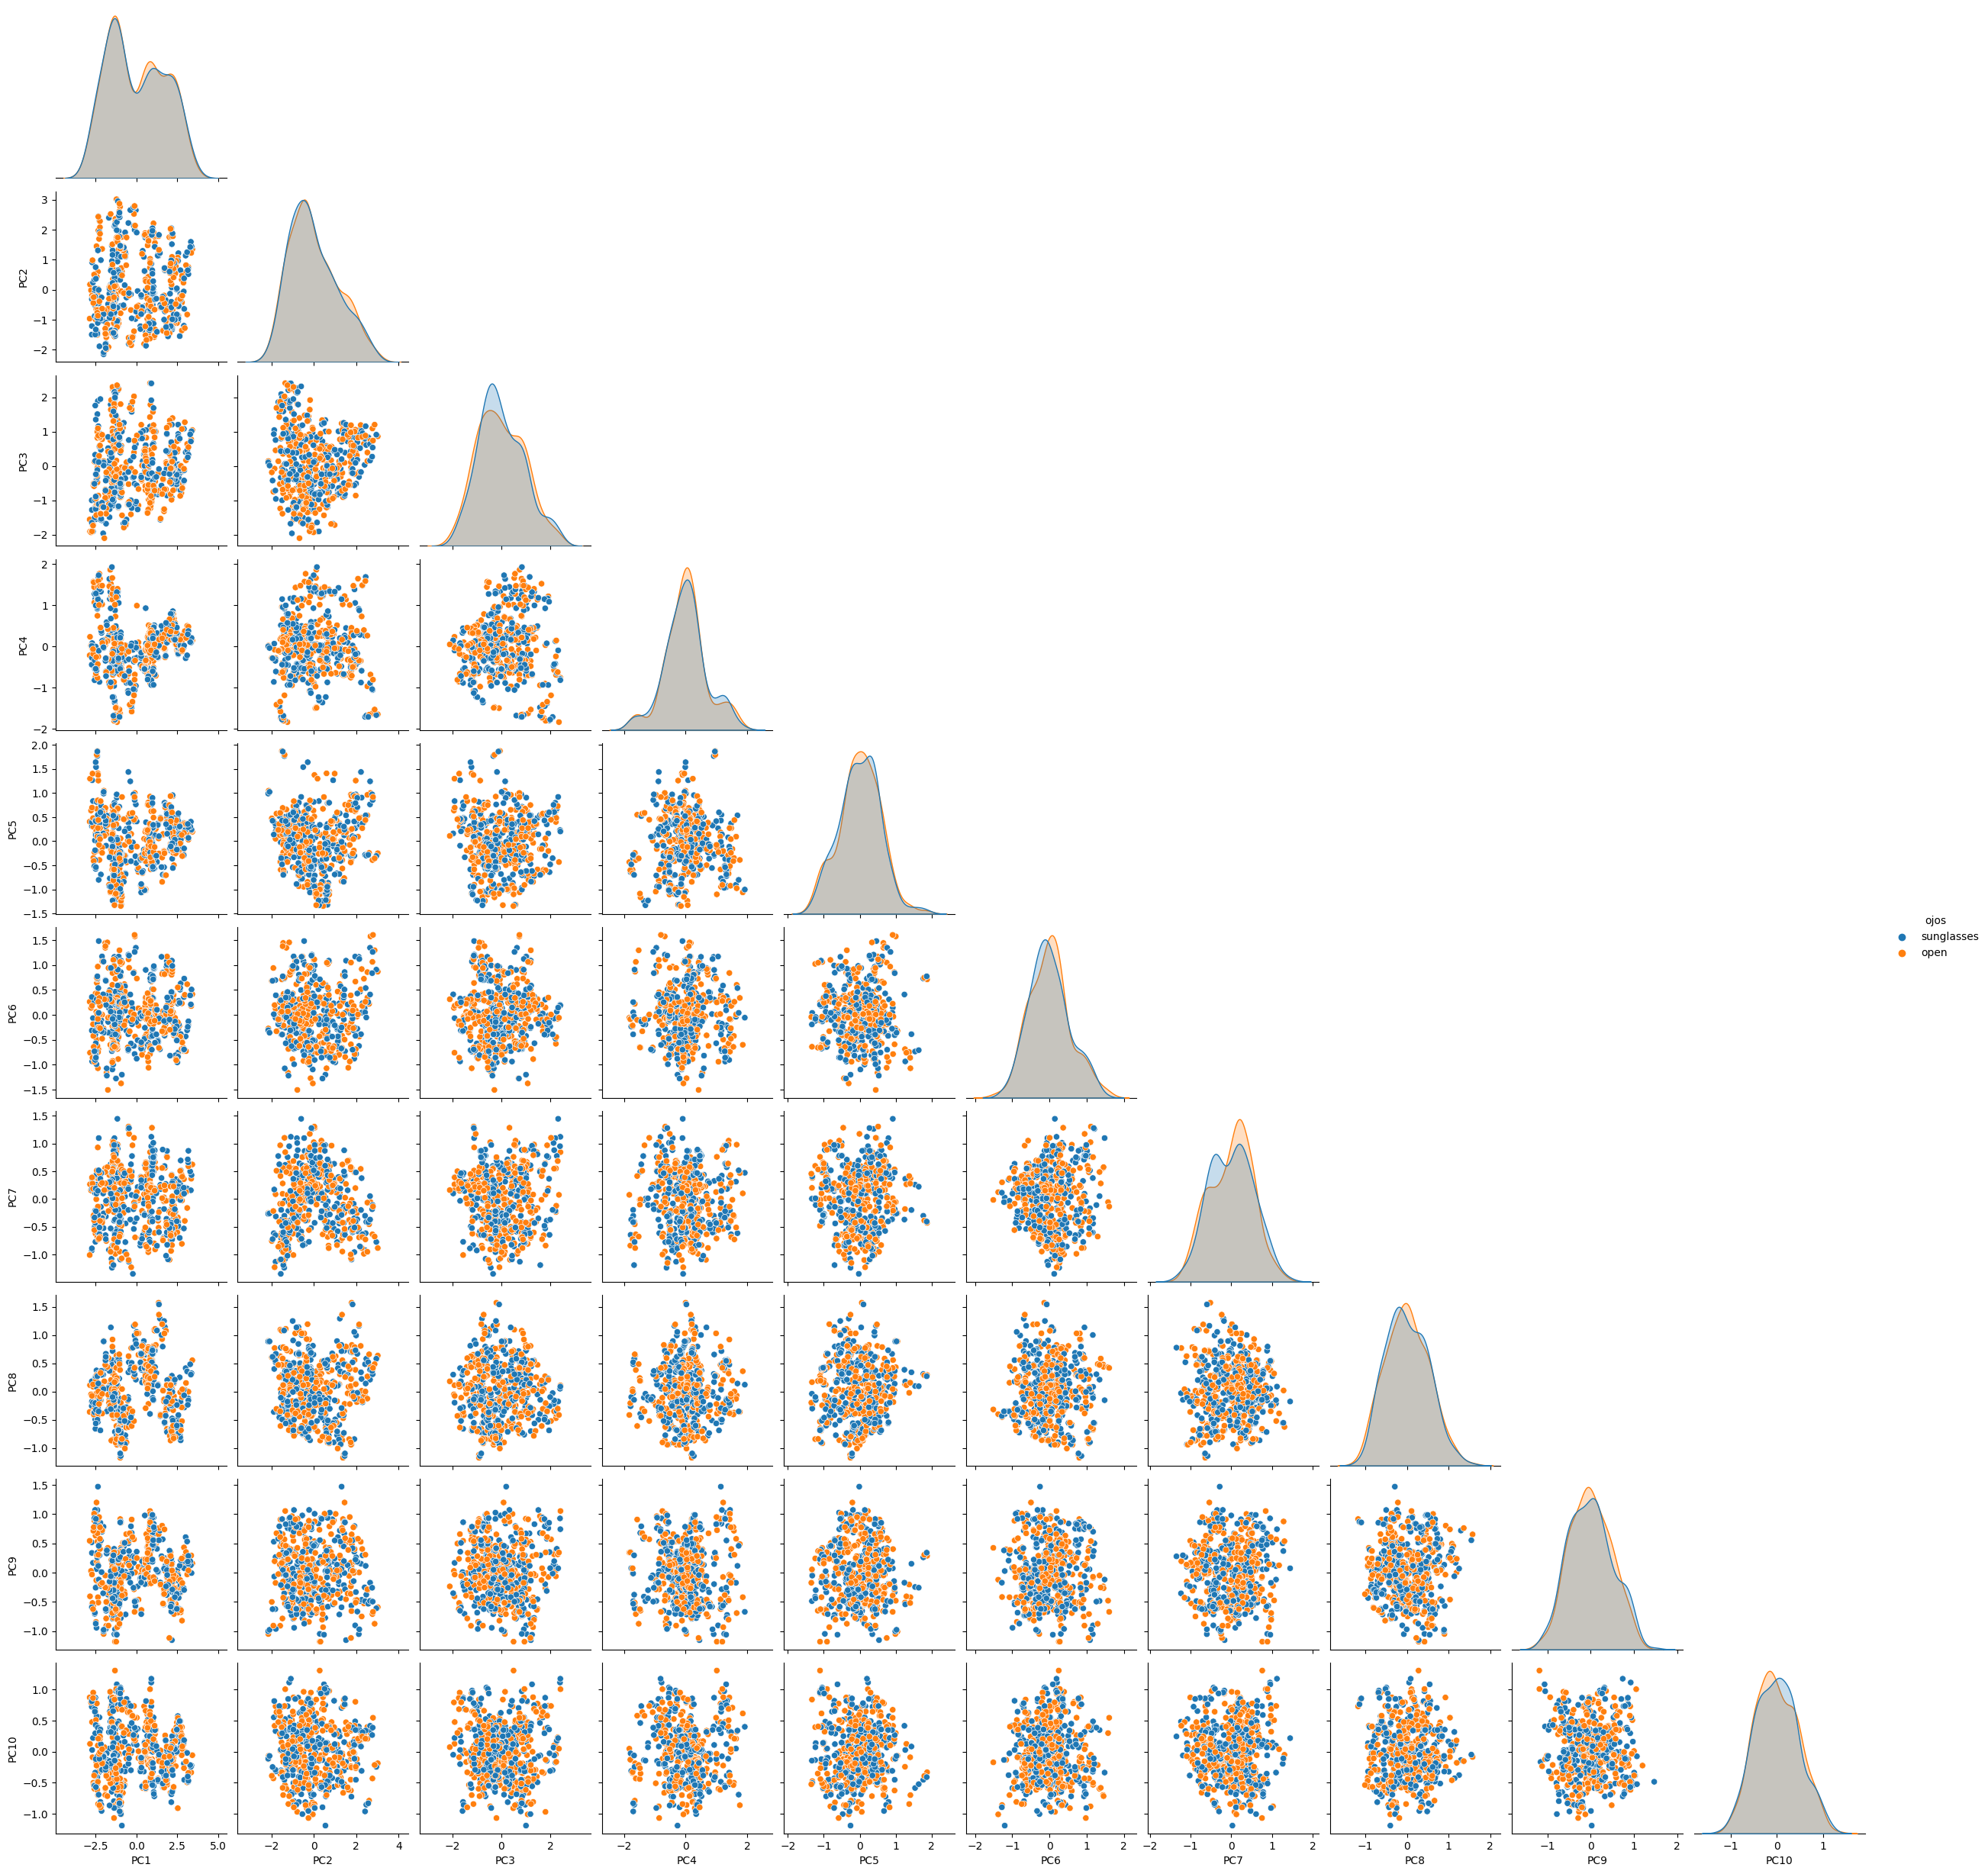

In [276]:
sns.pairplot(Proy2, hue = 'ojos', corner = True)

In [277]:
Proy2.corr(numeric_only=True)

PC1           PC2           PC3           PC4           PC5  \
PC1   1.000000e+00  3.260765e-16  1.996084e-16  4.182520e-16  1.487855e-16   
PC2   3.260765e-16  1.000000e+00  1.296393e-16  1.975671e-16 -1.110133e-16   
PC3   1.996084e-16  1.296393e-16  1.000000e+00 -4.965196e-16  1.039685e-16   
PC4   4.182520e-16  1.975671e-16 -4.965196e-16  1.000000e+00 -4.647345e-16   
PC5   1.487855e-16 -1.110133e-16  1.039685e-16 -4.647345e-16  1.000000e+00   
PC6  -2.730297e-16  5.667765e-17  1.573575e-16 -6.424348e-16  6.485092e-16   
PC7  -3.254977e-16  1.824162e-16 -5.980303e-17  2.279774e-16 -7.320958e-17   
PC8   3.003836e-16  3.020701e-17  3.824936e-17  1.051057e-16  3.766502e-17   
PC9  -4.526453e-16  7.806942e-16 -4.759383e-16  6.037404e-16 -2.189141e-16   
PC10  3.462920e-16 -1.552878e-16  2.257584e-16 -3.225606e-16  3.381955e-16   

               PC6           PC7           PC8           PC9          PC10  
PC1  -2.730297e-16 -3.254977e-16  3.003836e-16 -4.526453e-16  3.462920e-16  
PC2   5.667765e-17  1.824162e-16  3.020701e-17  7.806942e-16 -1.552878e-16  
PC3   1.573575e-16 -5.980303e-17  3.824936e-17 -4.759383e-16  2.257584e-16  
PC4  -6.424348e-16  2.279774e-16  1.051057e-16  6.037404e-16 -3.225606e-16  
PC5   6.485092e-16 -7.320958e-17  3.766502e-17 -2.189141e-16  3.381955e-16  
PC6   1.000000e+00 -1.593285e-16 -1.010876e-16  1.307731e-16 -1.328017e-16  
PC7  -1.593285e-16  1.000000e+00  2.182910e-16  8.211223e-16  6.743508e-17  
PC8  -1.010876e-16  2.182910e-16  1.000000e+00 -3.864880e-16  3.657295e-16  
PC9   1.307731e-16  8.211223e-16 -3.864880e-16  1.000000e+00 -2.383043e-16  
PC10 -1.328017e-16  6.743508e-17  3.657295e-16 -2.383043e-16  1.000000e+00

## **Análisis de imágenes por clase**

In [278]:
#Valores únicos en la variable objetivo
print(set(labels))

{'open', 'sunglasses'}


In [279]:
print({label: labels.count(label) for label in set(labels)})

{'open': 313, 'sunglasses': 311}


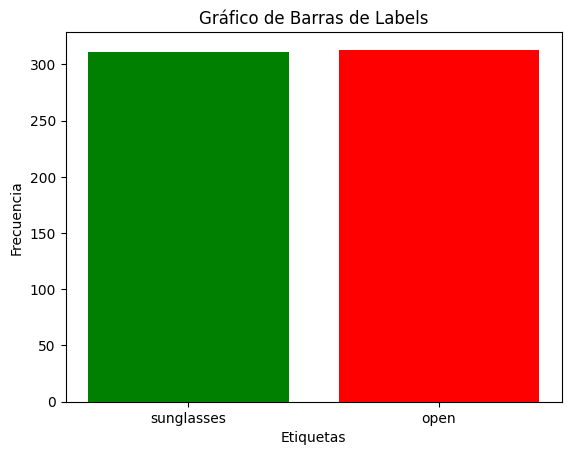

In [280]:
contador = Counter(labels)
etiquetas_unicas = list(contador.keys())
frecuencias = list(contador.values())

plt.bar(etiquetas_unicas, frecuencias, color=['green','red'])
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Labels')
plt.show()

Basándonos en los resultados previos, se concluye que de las 624 imágenes de caras, 313 no presentan gafas ('open'), mientras que 311 sí las tienen ('sunglasses').

Dado el número adecuado de datos para ambos valores únicos de la variable objetivo en el conjunto completo, no se considera necesario realizar un balanceo entre ellos.

# **Declaración de etiquetas y análisis de datos**

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

**Clasificación de imágenes**:

0 : open (sin gafas, ojos abiertos)

1 : sunglasses (con gafas)


<center>

La siguiente sección de código se utiliza para encontrar el número óptimo de componentes principales que expliquen el porcentaje objetivo de la varianza acumulativa en el gráfico de varianza explicada acumulativa, y se transforma el conjunto de datos con dicho parámetro.

In [281]:
pca = PCA()
pca.fit(imagenes_matriz)
porcentaje_varianza_objetivo = 0.95
n_componentes_optimo = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= porcentaje_varianza_objetivo) + 1

# Aplicar PCA con el número óptimo de componentes
pca_optimo = PCA(n_components=n_componentes_optimo)
X_transformado = pca_optimo.fit_transform(img_vectorizadas)

print(f'Número óptimo de componentes: {n_componentes_optimo}')

Número óptimo de componentes: 73


A continuación se hace una estandarización del conjunto de datos anterior y se realiza la división de los mismos en entrenamiento (70%) , prueba (15%) y validación (15%)

In [282]:
scaler = StandardScaler()
imagenes_estandarizadas = scaler.fit_transform(X_transformado)

In [283]:
#Partición de los datos en train 70%, test 15%, y validation 15%
X_train, X_temp, y_train, y_temp = train_test_split(imagenes_estandarizadas, labels, test_size=0.3, random_state=42)

# Dividir el conjunto temporal para obtener conjuntos de validación y prueba
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **Elección del modelo**

In [284]:
############## ESTO ES PARA LEER Y GUARDAR ARCHIVOS EN DRIVE

# #CODIGO INICIAL PARA AÑADIR TODAS LAS IMAGENES A UN LISTA ESTÁTICA, Y ASÍ NO TENER QUE CARGAR TODAS LAS IMÁGENES CADA VEZ QUE SE EJECUTE EL CÓDGO

# # Ruta a la carpeta raíz que contiene las subcarpetas con las imágenes PGM
# ruta_raiz = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4'
# rutas_imagenes = []
# # Recorre las subcarpetas y busca las imágenes PGM
# for directorio_raiz, directorios, archivos in os.walk(ruta_raiz):
#     for archivo in archivos:
#         if archivo.lower().endswith('.pgm'):
#             # Construye la ruta completa al archivo
#             ruta_completa = os.path.join(directorio_raiz, archivo)
#             rutas_imagenes.append(ruta_completa)
# # Ahora tienes todas las rutas de las imágenes PGM en la lista rutas_imagenes
# # Puedes cargar las imágenes si es necesario

# etiquetas = [ruta for ruta in rutas_imagenes]

# # # Para verificar la cantidad de imágenes

# # # Para acceder a una imagen específica
# # print(set(etiquetas))



# # Ruta en Google Drive donde guardar el archivo
# ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'
# with open(ruta_archivo, 'wb') as archivo:
#     pickle.dump(etiquetas, archivo)